In [299]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [300]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pylhe

from Mu2e import plot_tools, const, models

In [301]:
# Define the path to the MadGraph directory
path_to_madgraph = os.path.expanduser('~/Development/MG5_aMC_v3_5_3')  # NOTE: Change this to your MadGraph installation path
notebook_path = os.getcwd( )

In [7]:
def get_events(filename):
    mg5events = pylhe.read_lhe_with_attributes(filename)

    # Create akward array objects for convinience
    mg5events = pylhe.to_awkward(mg5events)

    return mg5events

def get_spectrum_in_bins(p, bins, weights = None):
    di, _ = np.histogram(p, bins, weights = weights)
    return np.array(di)

## MadGraph functions

In [8]:
def get_mgevents_mucapture(model, process='mu- pp > vm chi1 e+ e-', output='MuonCaptureModel1', generate=True, HTML_opening=False, nevents=1e3):

    if model.muon_capture_open:
        full_output_path = f'{notebook_path}/MGevents/{output}'
        custom_name = f'custom_run_{model.m1:.2e}_{model.m2:.2e}_{model.maprime:.2e}'
        
        # Create a command file with all the instructions for MadGraph
        mg5_commands = f"""
        set automatic_html_opening {HTML_opening}
        import model ExoticMuonCaptureModel1
        generate {process} QEDp<=5
        output {full_output_path}
        launch -n {custom_name} {full_output_path} 
        0
        set ptl -1
        set etal -1
        set etalmin -1
        set drll -1
        set nevents 50000
        set ebeam1 0.00001
        set ebeam2 0.00001
        set Mchi1 {model.m1:.2e}
        set Mchi2 {model.m2:.2e}
        set MAp {model.maprime:.2e}
        set nevents {int(nevents)}"
        0
        """

        if generate:
            # Save the commands to a file
            with open('mg5_script.txt', 'w') as file:
                file.write(mg5_commands)

            # Run the MadGraph script
            os.system(f'{path_to_madgraph}/bin/mg5_aMC mg5_script.txt > {notebook_path}/MGevents/MGlogfile.txt')

        # Move the LHE events to the desired path
        lhe_file_path = f'{full_output_path}/Events/{custom_name}/unweighted_events.lhe.gz'
        
        # Collect events after unzipping
        return get_events(lhe_file_path)
    else:
        print("Muon capture kinematically forbidden.")
        return None

In [213]:
def get_mgevents_pdecay(model, process='pp > e+ vm~ ve vm chi1 e+ e-', output='ProtonDecayModel1', generate=True, HTML_opening=False, nevents=1e3, set_muon_width=True):
    
    if len(model.get_open_pdecay_channels()) > 1:
        print("Decay channels:", model.get_open_pdecay_channels())
        # raise ValueError('Multiple proton decay channels detected')

    full_output_path = f'{notebook_path}/MGevents/{output}'
    custom_name = f'custom_run_{model.m1:.2e}_{model.m2:.2e}_{model.maprime:.2e}'
    
    # Create a command file with all the instructions for MadGraph
    mg5_commands = f"""
    set automatic_html_opening {HTML_opening}
    import model ExoticMuonCaptureModel1
    generate {process} QEDp=5
    output {full_output_path}
    launch -n {custom_name} {full_output_path} 
    0
    set ptl -1
    set etal -1
    set etalmin -1
    set drll -1
    set ebeam1 0
    set ebeam2 0
    set Mchi1 {model.m1:.4e}
    set Mchi2 {model.m2:.4e}
    set MAp {model.maprime:.4e}
    set lambda 1
    set tcon 1
    set epsilon {model.epsilon:.4e}
    set Wap {model.GammaAprime:.4e}
    set Wchi2 {model.Gammachi2:.4e}
    {'set decay 13 3.000000e-19' if set_muon_width else ''}
    set nevents {int(nevents)}"
    0
    """

    if generate:
        # Save the commands to a file
        with open('mg5_script.txt', 'w') as file:
            file.write(mg5_commands)

        # Run the MadGraph script
        os.system(f'{path_to_madgraph}/bin/mg5_aMC mg5_script.txt > {notebook_path}/MGevents/MGlogfile.txt')

    # Move the LHE events to the desired path
    lhe_file_path = f'{full_output_path}/Events/{custom_name}/unweighted_events.lhe.gz'
    
    # Collect events after unzipping
    return get_events(lhe_file_path)

## Model benchmarks

In [192]:
Lambda_NP = 1e6
Gmup = 1/(Lambda_NP)**2

Benchmark1 = models.MuonCaptureModelI(m1=0.940, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = 0.1)
Benchmark2 = models.MuonCaptureModelI(m1=0.835, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = 0.1)
Benchmark3 = models.MuonCaptureModelI(m1=0.900, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = 0.1)
Benchmark4 = models.MuonCaptureModelI(m1=0.880, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = 0.1)

Benchmark1b = models.MuonCaptureModelI(m1=0.940, m2=1.030, maprime=0.045, Gmup=Gmup, alphaD = 0.1)
Benchmark2b = models.MuonCaptureModelI(m1=0.835, m2=1.030, maprime=0.045, Gmup=Gmup, alphaD = 0.1)
Benchmark3b = models.MuonCaptureModelI(m1=0.900, m2=1.030, maprime=0.045, Gmup=Gmup, alphaD = 0.1)
Benchmark4b = models.MuonCaptureModelI(m1=0.880, m2=1.030, maprime=0.045, Gmup=Gmup, alphaD = 0.1)

In [193]:
Benchmark3.get_mu_capture_rate()
LambdaQCD = 0.140
MED_SCALE = (LambdaQCD**3/Gmup)**(1/5)

MED_SCALE 

epsilon=1e-4
m_nu = 1e-12*const.vev_EW
Gmup*const.Gf*const.vev_EW**4*(1/16/np.pi**2)**3*(0.3*epsilon)*(m_nu)
# Gmup*const.Gf*const.vev_EW**4*(1/16/np.pi**2)**3*(0.3*epsilon)*(1e-15 * 1e-9)
1/const.get_decay_rate_in_cm(1e-45) * 1e8 * 1e10

5.067730716548338e-14

In [195]:
print(Benchmark1.get_aprime_tau0())
print(Benchmark1.get_chi2_tau0())
print(Benchmark1.get_mu_capture_rate())

1.3529844592864736e-09
5.806770395141065e-19
3.1296970954067873e-15


## Muon capture studies

In [23]:
mucapture_1 = get_mgevents_mucapture(Benchmark1, generate=True, nevents=1e4)
mucapture_2 = get_mgevents_mucapture(Benchmark2, generate=True, nevents=1e4)
mucapture_3 = get_mgevents_mucapture(Benchmark3, generate=True, nevents=1e4)
mucapture_4 = get_mgevents_mucapture(Benchmark4, generate=True, nevents=1e4)

weights_mucapture_1 = mucapture_1['eventinfo','weight'].to_numpy()/mucapture_1['eventinfo','weight'].to_numpy().sum() * Benchmark1.get_mu_capture_rate()
weights_mucapture_2 = mucapture_2['eventinfo','weight'].to_numpy()/mucapture_2['eventinfo','weight'].to_numpy().sum() * Benchmark2.get_mu_capture_rate()
weights_mucapture_3 = mucapture_3['eventinfo','weight'].to_numpy()/mucapture_3['eventinfo','weight'].to_numpy().sum() * Benchmark3.get_mu_capture_rate()
weights_mucapture_4 = mucapture_4['eventinfo','weight'].to_numpy()/mucapture_4['eventinfo','weight'].to_numpy().sum() * Benchmark4.get_mu_capture_rate()

stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 160181.15it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 154922.04it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 150442.16it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 157149.35it/s]


In [24]:
mucapture_1b = get_mgevents_mucapture(Benchmark1b, generate=True, nevents=1e4)
mucapture_2b = get_mgevents_mucapture(Benchmark2b, generate=True, nevents=1e4)
mucapture_3b = get_mgevents_mucapture(Benchmark3b, generate=True, nevents=1e4)
mucapture_4b = get_mgevents_mucapture(Benchmark4b, generate=True, nevents=1e4)

weights_mucapture_1b = mucapture_1b['eventinfo','weight'].to_numpy()/mucapture_1b['eventinfo','weight'].to_numpy().sum() * Benchmark1b.get_mu_capture_rate()
weights_mucapture_2b = mucapture_2b['eventinfo','weight'].to_numpy()/mucapture_2b['eventinfo','weight'].to_numpy().sum() * Benchmark2b.get_mu_capture_rate()
weights_mucapture_3b = mucapture_3b['eventinfo','weight'].to_numpy()/mucapture_3b['eventinfo','weight'].to_numpy().sum() * Benchmark3b.get_mu_capture_rate()
weights_mucapture_4b = mucapture_4b['eventinfo','weight'].to_numpy()/mucapture_4b['eventinfo','weight'].to_numpy().sum() * Benchmark4b.get_mu_capture_rate()

stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 160244.40it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 151580.11it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 157225.46it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 160378.98it/s]


In [25]:
def mu_capture_kinematics(mgevents):
    electrons = (mgevents['particles', 'id'] == 11)
    positrons = (mgevents['particles', 'id'] == -11)
    neutrinos = (np.abs(mgevents['particles', 'id']) == 12) | (np.abs(mgevents['particles', 'id']) == 14)
    chi1s = (np.abs(mgevents['particles', 'id']) == 999901) 

    p_positron = np.array([np.array(mgevents["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    p_electron = np.array([np.array(mgevents["particles", "vector", ind][electrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    ptot = (p_positron + p_electron).T

    kin = {}
    kin['E_positron'] = mgevents['particles','vector','t'][positrons].to_numpy().sum(axis=1)
    kin['E_electron'] = mgevents['particles','vector','t'][electrons].to_numpy().sum(axis=1)
    kin['p_positron'] = np.sqrt(kin['E_positron']**2 + const.m_e**2)
    kin['p_electron'] = np.sqrt(kin['E_electron']**2 + const.m_e**2)
    kin['E_neutrino'] = mgevents['particles','vector','t'][neutrinos].to_numpy().sum(axis=1)
    kin['E_chi1'] = mgevents['particles','vector','t'][chi1s].to_numpy().sum(axis=1)
    kin['E_vis'] = kin['E_electron'] + kin['E_positron']
    kin['T_vis'] = kin['E_vis'] - 2*const.m_e
    kin['E_inv'] = kin['E_neutrino'] + kin['E_chi1']
    kin['E_asy'] = np.abs(kin['E_electron'] - kin['E_positron']) / (kin['E_electron'] + kin['E_positron'])
    kin['m_ee'] = np.sqrt(ptot[:, 0]**2 - ptot[:, 1]**2 - ptot[:, 2]**2 - ptot[:, 3]**2)

    return kin

In [26]:
kin_1 = mu_capture_kinematics(mucapture_1)
kin_2 = mu_capture_kinematics(mucapture_2)
kin_3 = mu_capture_kinematics(mucapture_3)
kin_4 = mu_capture_kinematics(mucapture_4)

kin_1b = mu_capture_kinematics(mucapture_1b)
kin_2b = mu_capture_kinematics(mucapture_2b)
kin_3b = mu_capture_kinematics(mucapture_3b)
kin_4b = mu_capture_kinematics(mucapture_4b)

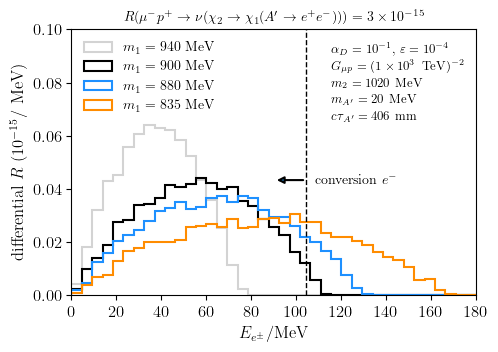

In [292]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0, 180, 40)
cmap = plt.get_cmap('viridis')
norm = 1e15
# Plot thm_1 = e histogram
ax.hist(kin_1['E_electron']*1e3, weights=norm*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='lightgrey', label=rf'$m_1 = {Benchmark1.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_3['E_electron']*1e3, weights=norm*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='black', label=rf'$m_1 = {Benchmark3.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_4['E_electron']*1e3, weights=norm*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='dodgerblue', label=rf'$m_1 = {Benchmark4.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_2['E_electron']*1e3, weights=norm*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='darkorange', label=rf'$m_1 = {Benchmark2.m1*1e3:.0f}$ MeV', lw=1.5)

# # Plot the histogram
# ax.hist(kin_1['E_positron']*1e3, weights=1e14*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$E_{e^\pm}$/MeV')
ax.set_ylabel(r'differential $R$ ($10^{-15}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_2.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
text_descriptor = rf"\noindent$\alpha_D = 10^{{-1}}, \, \varepsilon = 10^{{-4}}$\\$G_{{\mu p}} = ({Benchmark1.tex_scale}$ \,TeV$)^{{-2}}$\\$m_2 = {Benchmark1.m2*1e3:.0f}$ MeV\\$m_{{A^\prime}} = {Benchmark1.maprime*1e3:.0f}$ MeV\\$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():0.0f}$~mm"
ax.text(0.64, 0.95, text_descriptor, transform=ax.transAxes, fontsize=9, verticalalignment='top')

ax.legend(loc='upper left', fontsize=10, frameon=False)

ax.vlines(104.2, 0, 2, color='black', linestyle='dashed', linewidth=1)

# Add arrow to the left attached to the vline
ax.annotate('', xy=(104.2, 0.13/3), xytext=(90, 0.13/3), arrowprops=dict(arrowstyle='<|-', lw=1.5))
ax.annotate('conversion $e^-$', xy=(145, 0.041), fontsize=10, ha='right', va = 'bottom')

# Set x ticks
ax.set_xticks(np.arange(0, 200, 20))
ax.set_ylim(0,0.1)
ax.set_xlim(0, 180)

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1_energies.pdf', dpi=300)

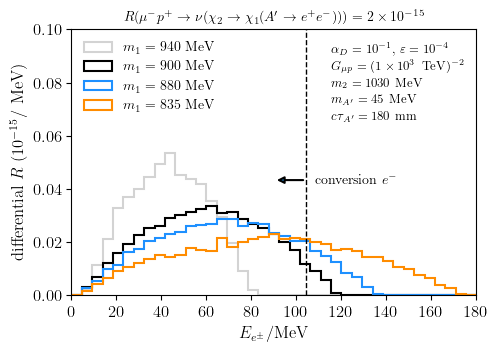

In [294]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0, 180, 40)
cmap = plt.get_cmap('viridis')
norm = 1e15
# Plot thm_1 = e histogram
ax.hist(kin_1b['E_electron']*1e3, weights=norm*weights_mucapture_1b/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='lightgrey', label=rf'$m_1 = {Benchmark1b.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_3b['E_electron']*1e3, weights=norm*weights_mucapture_3b/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='black', label=rf'$m_1 = {Benchmark3b.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_4b['E_electron']*1e3, weights=norm*weights_mucapture_4b/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='dodgerblue', label=rf'$m_1 = {Benchmark4b.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_2b['E_electron']*1e3, weights=norm*weights_mucapture_2b/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='darkorange', label=rf'$m_1 = {Benchmark2b.m1*1e3:.0f}$ MeV', lw=1.5)

# # Plot the histogram
# ax.hist(kin_1['E_positron']*1e3, weights=1e14*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$E_{e^\pm}$/MeV')
ax.set_ylabel(r'differential $R$ ($10^{-15}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_2b.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
text_descriptor = rf"\noindent$\alpha_D = 10^{{-1}},\, \varepsilon = 10^{{-4}}$\\$G_{{\mu p}} = ({Benchmark1b.tex_scale}$ \,TeV$)^{{-2}}$\\$m_2 = {Benchmark1b.m2*1e3:.0f}$ MeV\\$m_{{A^\prime}} = {Benchmark1b.maprime*1e3:.0f}$ MeV\\$c\tau_{{A^\prime}} = {Benchmark1b.get_aprime_ctau0():0.0f}$~mm"
ax.text(0.64, 0.95, text_descriptor, transform=ax.transAxes, fontsize=9, verticalalignment='top')

ax.legend(loc='upper left', fontsize=10, frameon=False)

ax.vlines(104.2, 0, 2, color='black', linestyle='dashed', linewidth=1)

# Add arrow to the left attached to the vline
ax.annotate('', xy=(104.2, 0.13/3), xytext=(90, 0.13/3), arrowprops=dict(arrowstyle='<|-', lw=1.5))
ax.annotate('conversion $e^-$', xy=(145, 0.041), fontsize=10, ha='right', va = 'bottom')

# Set x ticks
ax.set_xticks(np.arange(0, 200, 20))
ax.set_ylim(0,0.1)
ax.set_xlim(0, 180)

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1b_energies.pdf', bbox_inches='tight', dpi=300)

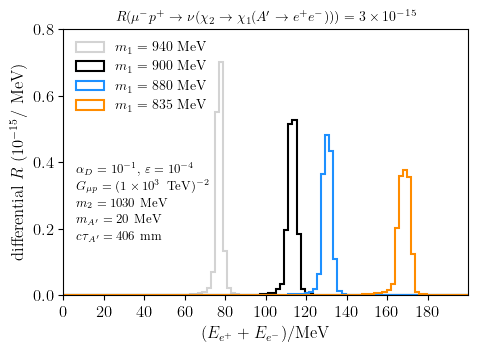

In [655]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0, 200, 100)
cmap = plt.get_cmap('viridis')
norm = 1e15
# Plot thm_1 = e histogram
ax.hist(kin_1['E_vis']*1e3, weights=norm*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='lightgrey', label=rf'$m_1 = {Benchmark1.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_3['E_vis']*1e3, weights=norm*weights_mucapture_3/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='black', label=rf'$m_1 = {Benchmark3.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_4['E_vis']*1e3, weights=norm*weights_mucapture_4/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='dodgerblue', label=rf'$m_1 = {Benchmark4.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_2['E_vis']*1e3, weights=norm*weights_mucapture_2/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='darkorange', label=rf'$m_1 = {Benchmark2.m1*1e3:.0f}$ MeV', lw=1.5)

# ax.vlines((1020**2 + 20**2 - (Benchmark1.m1*1e3)**2)/2/1020, 0, 1, color='black', linestyle='dashed', linewidth=1)
# ax.vlines((1020**2 + 20**2 - (Benchmark2.m1*1e3)**2)/2/1020, 0, 1, color='black', linestyle='dashed', linewidth=1)
# ax.vlines((1020**2 + 20**2 - (Benchmark3.m1*1e3)**2)/2/1020, 0, 1, color='black', linestyle='dashed', linewidth=1)
# ax.vlines((1020**2 + 20**2 - (Benchmark4.m1*1e3)**2)/2/1020, 0, 1, color='black', linestyle='dashed', linewidth=1)

# # Plot the histogram
# ax.hist(kin_1['E_positron']*1e3, weights=1e14*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$(E_{e^+} + E_{e^-})$/MeV')
ax.set_ylabel(r'differential $R$ ($10^{-15}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_1.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
text_descriptor = rf"\noindent$\alpha_D = 10^{{-1}},\, \varepsilon = 10^{{-4}}$\\$G_{{\mu p}} = ({Benchmark1.tex_scale}$ \,TeV$)^{{-2}}$\\$m_2 = {Benchmark1b.m2*1e3:.0f}$ MeV\\$m_{{A^\prime}} = {Benchmark1.maprime*1e3:.0f}$ MeV\\$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():0.0f}$~mm"
ax.text(0.03, 0.5, text_descriptor, transform=ax.transAxes, fontsize=9, verticalalignment='top')

ax.legend(loc='upper left', fontsize=10, ncols=1
          , frameon=False)

# Set x ticks
ax.set_xticks(np.arange(0, 200, 20))
ax.set_ylim(0,0.8)
ax.set_xlim(0, bins.max())

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1_total_energy.pdf', dpi=300)

77.05882352941177

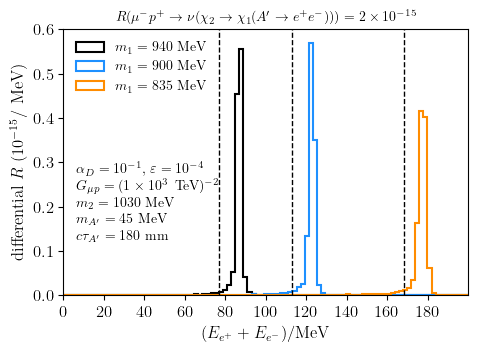

In [653]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0, 200, 100)
cmap = plt.get_cmap('viridis')
norm = 1e15
# Plot thm_1 = e histogram
ax.hist(kin_1b['E_vis']*1e3, weights=norm*weights_mucapture_1b/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='black', label=rf'$m_1 = {Benchmark1b.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_3b['E_vis']*1e3, weights=norm*weights_mucapture_1b/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='dodgerblue', label=rf'$m_1 = {Benchmark3b.m1*1e3:.0f}$ MeV', lw=1.5)
ax.hist(kin_2b['E_vis']*1e3, weights=norm*weights_mucapture_1b/(bins[1]-bins[0]), bins=bins, histtype='step', edgecolor='darkorange', label=rf'$m_1 = {Benchmark2b.m1*1e3:.0f}$ MeV', lw=1.5)
ax.vlines((1020**2 + 20**2 - (Benchmark1b.m1*1e3)**2)/2/1020, 0, 1, color='black', linestyle='dashed', linewidth=1)
ax.vlines((1020**2 + 20**2 - (Benchmark3b.m1*1e3)**2)/2/1020, 0, 1, color='black', linestyle='dashed', linewidth=1)
ax.vlines((1020**2 + 20**2 - (Benchmark2b.m1*1e3)**2)/2/1020, 0, 1, color='black', linestyle='dashed', linewidth=1)

# # Plot the histogram
# ax.hist(kin_1['E_positron']*1e3, weights=1e14*weights_mucapture_1/(bins[1]-bins[0]), bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$(E_{e^+} + E_{e^-})$/MeV')
ax.set_ylabel(r'differential $R$ ($10^{-15}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_2b.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
text_descriptor = rf"\noindent$\alpha_D = 10^{{-1}},\, \varepsilon = 10^{{-4}}$\\$G_{{\mu p}} = ({Benchmark1b.tex_scale}$ \,TeV$)^{{-2}}$\\$m_2 = {Benchmark1b.m2*1e3:.0f}$ MeV\\$m_{{A^\prime}} = {Benchmark1b.maprime*1e3:.0f}$ MeV\\$c\tau_{{A^\prime}} = {Benchmark1b.get_aprime_ctau0():0.0f}$~mm"
ax.text(0.03, 0.5, text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.legend(loc='upper left', fontsize=10, ncols=1
          , frameon=False)

# Set x ticks
ax.set_xticks(np.arange(0, 200, 20))
ax.set_ylim(0,0.6
            )
ax.set_xlim(0, bins.max())

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1b_total_energy.pdf', bbox_inches='tight', dpi=300)

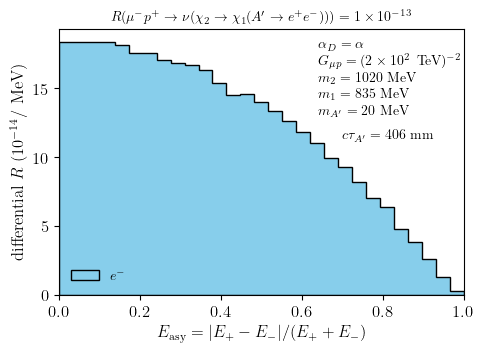

In [31]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0,1, 30)

# Plot the histogram
ax.hist(kin_2['E_asy'], weights=1e14*weights_mucapture_2/(bins[1]-bins[0]), bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='$e^-$')

# Set labels and title
ax.set_xlabel(r'$E_{\rm asy} = |E_+ - E_-| / (E_+ + E_-)$')
ax.set_ylabel(r'differential $R$ ($10^{-14}$/ MeV)')
ax.set_title(fr'$R(\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))) = {plot_tools.sci_notation(weights_mucapture_2.sum(), notex=True, decimal_digits=0)}$', fontsize=10)

# ax.set_yscale('log')

# Add the text box
ax.text(0.64, 0.95, Benchmark2.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.7, 0.62, fr'$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():.0f}$~mm', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.legend(loc='lower left', fontsize=10, frameon=False)

ax.vlines(104.2, 0, 2, color='black', linestyle='dashed', linewidth=1)

# Add arrow to the left attached to the vline
ax.annotate('', xy=(104.2, 1), xytext=(90, 1), arrowprops=dict(arrowstyle='<|-', lw=1.5))
ax.annotate('conversion $e^-$', xy=(102, 1.05), fontsize=10, ha='right', va = 'bottom')

# Set x ticks
ax.set_xlim(0,1)

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1_m1_{Benchmark2.m1*1e3:.0f}_Easy.png', bbox_inches='tight', dpi=300)

## Proton decay studies

In [403]:
def get_p_lifetime(model):
    """ Get the proton lifetime in 1e32 years """
    pevents = get_mgevents_pdecay(model, generate=True, process='pp > e+ vm~ ve vm chi1 Ap', nevents=1e4)
    g = (pevents['eventinfo','weight'].to_numpy() / len(pevents)).sum() * model.pdecay_rescale
    return const.get_decay_rate_in_1e32_years(g)

def get_p_lifetime_offshell(model):
    """ Get the proton lifetime in 1e32 years including off-shell A' decays """
    pevents = get_mgevents_pdecay(model, generate=True, process='pp > e+ vm~ ve vm chi1 e+ e-', nevents=1e4)
    g = (pevents['eventinfo','weight'].to_numpy() / len(pevents)).sum() * model.pdecay_rescale
    return const.get_decay_rate_in_1e32_years(g)

def get_p_events(benchmark):
    """ Get the proton decay events including off-shell A' decays"""
    pdecay = get_mgevents_pdecay(benchmark, generate=True, process='pp > e+ vm~ ve vm chi1 e+ e-', nevents=1e4)
    gamma_tot = (pdecay['eventinfo','weight'].to_numpy() / len(pdecay)).sum() * benchmark.pdecay_rescale
    weights = pdecay['eventinfo','weight'].to_numpy() / pdecay['eventinfo','weight'].to_numpy().sum() * const.get_decay_rate_in_1e32_years(gamma_tot)
    return pdecay, weights

In [215]:
pdecay_2, weights_pdecay_2 = get_p_events(Benchmark2)
pdecay_3, weights_pdecay_3 = get_p_events(Benchmark3)
pdecay_4, weights_pdecay_4 = get_p_events(Benchmark4)

stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 98729.89it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 100658.36it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 101239.68it/s]


In [327]:
Benchmark2c = models.MuonCaptureModelI(m1=0.835, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = const.alphaQED, epsilon=1)
Benchmark3c = models.MuonCaptureModelI(m1=0.900, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = const.alphaQED, epsilon=1)
Benchmark4c = models.MuonCaptureModelI(m1=0.880, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = const.alphaQED, epsilon=1)
Benchmark5c = models.MuonCaptureModelI(m1=0.910, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD = const.alphaQED, epsilon=1)


In [328]:
pdecay_2c, weights_pdecay_2c = get_p_events(Benchmark2c)
pdecay_3c, weights_pdecay_3c = get_p_events(Benchmark3c)
pdecay_4c, weights_pdecay_4c = get_p_events(Benchmark4c)
pdecay_5c, weights_pdecay_5c = get_p_events(Benchmark5c)

stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 101799.96it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 90281.48it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 88594.83it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 95044.59it/s]


In [335]:
def p_decay_kinematics(mgevents):
    electrons = (mgevents['particles', 'id'] == 11)
    positrons = (mgevents['particles', 'id'] == -11)
    neutrinos = (np.abs(mgevents['particles', 'id']) == 12) | (np.abs(mgevents['particles', 'id']) == 14)
    chi1s = (np.abs(mgevents['particles', 'id']) == 999901) 

    p_positron_1 = np.array([np.array(mgevents["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    p_positron_2 = np.array([np.array(mgevents["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,1]
    p_electron = np.array([np.array(mgevents["particles", "vector", ind][electrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    ptot = (p_positron_1 + p_positron_2 + p_electron).T
    pee1 = (p_positron_1 + p_electron).T
    pee2 = (p_positron_2 + p_electron).T

    kin = {}
    kin['E_positrons'] = mgevents['particles','vector','t'][positrons].to_numpy().sum(axis=1)
    kin['E_electrons'] = mgevents['particles','vector','t'][electrons].to_numpy().sum(axis=1)
    kin['E_neutrinos'] = mgevents['particles','vector','t'][neutrinos].to_numpy().sum(axis=1)
    kin['E_chi1'] = mgevents['particles','vector','t'][chi1s].to_numpy().sum(axis=1)
    kin['E_vis'] = kin['E_electrons'] + kin['E_positrons']
    kin['T_vis'] = kin['E_vis'] - 2*const.m_e
    kin['E_inv'] = kin['E_neutrinos'] + kin['E_chi1']
    kin['E_asy'] = np.abs(kin['E_electrons'] - kin['E_positrons']) / (kin['E_electrons'] + kin['E_positrons'])
    kin['m_eee'] = np.sqrt(ptot[:, 0]**2 - ptot[:, 1]**2 - ptot[:, 2]**2 - ptot[:, 3]**2)
    kin['m_ee1'] = np.sqrt(pee1[:, 0]**2 - pee1[:, 1]**2 - pee1[:, 2]**2 - pee1[:, 3]**2)
    kin['m_ee2'] = np.sqrt(pee2[:, 0]**2 - pee2[:, 1]**2 - pee2[:, 2]**2 - pee2[:, 3]**2)
    
    return kin


In [336]:
kin_pdecay_2 = p_decay_kinematics(pdecay_2)
kin_pdecay_3 = p_decay_kinematics(pdecay_3)
kin_pdecay_4 = p_decay_kinematics(pdecay_4)

kin_pdecay_2c = p_decay_kinematics(pdecay_2c)
kin_pdecay_3c = p_decay_kinematics(pdecay_3c)
kin_pdecay_4c = p_decay_kinematics(pdecay_4c)
kin_pdecay_5c = p_decay_kinematics(pdecay_5c)

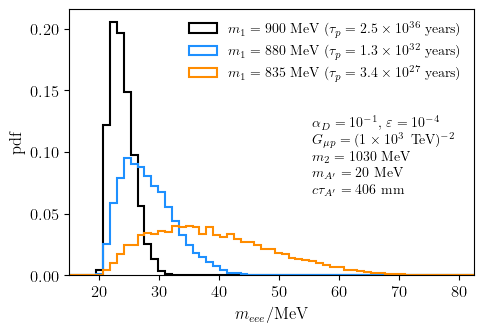

In [337]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(15, np.max(kin_pdecay_2['m_eee'])*1e3, 60)
ax.hist(kin_pdecay_3['m_eee']*1e3, weights=weights_pdecay_3/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='black', label=rf'$m_1 = {Benchmark3.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_3.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_4['m_eee']*1e3, weights=weights_pdecay_4/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='dodgerblue', label=rf'$m_1 = {Benchmark4.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_4.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_2['m_eee']*1e3, weights=weights_pdecay_2/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='darkorange', label=rf'$m_1 = {Benchmark2.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_2.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)


# Set labels and title
ax.set_xlabel(r'$m_{eee}$/MeV')
# ax.set_ylabel(r'${d \tau_{p}/d m_{eee}}$ ($10^{32}$ years/MeV)')
ax.set_ylabel(r'pdf')
# ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_2*1e32*1e3/, notex=True)}$ years', fontsize=10)

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_descriptor = rf"\noindent$\alpha_D = 10^{{-1}},\, \varepsilon = 10^{{-4}}$\\$G_{{\mu p}} = ({Benchmark1.tex_scale}$ \,TeV$)^{{-2}}$\\$m_2 = {Benchmark1b.m2*1e3:.0f}$ MeV\\$m_{{A^\prime}} = {Benchmark1.maprime*1e3:.0f}$ MeV\\$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():0.0f}$~mm"
ax.text(0.6, 0.6, text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.legend(loc='upper right', fontsize=10, ncols=1, frameon=False)

# Add the vertical dashed line
cutoff = (const.m_proton - Benchmark2.m1 - Benchmark2.maprime)*1e3
ax.axvline(cutoff, linestyle='dashed', color='grey')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_meee.pdf', dpi=300)

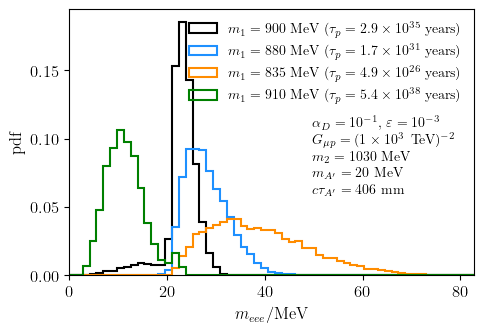

In [338]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, np.max(kin_pdecay_2c['m_eee'])*1e3, 60)
ax.hist(kin_pdecay_3c['m_eee']*1e3, weights=weights_pdecay_3c/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='black', label=rf'$m_1 = {Benchmark3c.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_3c.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_4c['m_eee']*1e3, weights=weights_pdecay_4c/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='dodgerblue', label=rf'$m_1 = {Benchmark4c.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_4c.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_2c['m_eee']*1e3, weights=weights_pdecay_2c/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='darkorange', label=rf'$m_1 = {Benchmark2c.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_2c.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_5c['m_eee']*1e3, weights=weights_pdecay_5c/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='green', label=rf'$m_1 = {Benchmark5c.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_5c.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)


# Set labels and title
ax.set_xlabel(r'$m_{eee}$/MeV')
# ax.set_ylabel(r'${d \tau_{p}/d m_{eee}}$ ($10^{32}$ years/MeV)')
ax.set_ylabel(r'pdf')
# ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_2*1e32*1e3/, notex=True)}$ years', fontsize=10)

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_descriptor = rf"\noindent$\alpha_D = 10^{{-1}},\, \varepsilon = 10^{{-3}}$\\$G_{{\mu p}} = ({Benchmark2c.tex_scale}$ \,TeV$)^{{-2}}$\\$m_2 = {Benchmark1b.m2*1e3:.0f}$ MeV\\$m_{{A^\prime}} = {Benchmark1.maprime*1e3:.0f}$ MeV\\$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():0.0f}$~mm"
ax.text(0.6, 0.6, text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.legend(loc='upper right', fontsize=10, ncols=1, frameon=False)

# Add the vertical dashed line
cutoff = (const.m_proton - Benchmark2.m1 - Benchmark2.maprime)*1e3
ax.axvline(cutoff, linestyle='dashed', color='grey')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1c_meee.pdf', dpi=300)

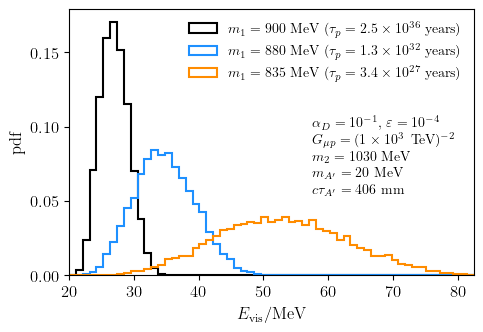

In [311]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(20, np.max(kin_pdecay_2['m_eee'])*1e3, 60)
ax.hist(kin_pdecay_3['E_vis']*1e3, weights=weights_pdecay_3/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='black', label=rf'$m_1 = {Benchmark3.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_3.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_4['E_vis']*1e3, weights=weights_pdecay_4/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='dodgerblue', label=rf'$m_1 = {Benchmark4.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_4.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_2['E_vis']*1e3, weights=weights_pdecay_2/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='darkorange', label=rf'$m_1 = {Benchmark2.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_2.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)


# Set labels and title
ax.set_xlabel(r'$E_{\rm vis}$/MeV')
# ax.set_ylabel(r'${d \tau_{p}/d m_{eee}}$ ($10^{32}$ years/MeV)')
ax.set_ylabel(r'pdf')
# ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_2*1e32*1e3/, notex=True)}$ years', fontsize=10)

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_descriptor = rf"\noindent$\alpha_D = 10^{{-1}},\, \varepsilon = 10^{{-4}}$\\$G_{{\mu p}} = ({Benchmark1.tex_scale}$ \,TeV$)^{{-2}}$\\$m_2 = {Benchmark1b.m2*1e3:.0f}$ MeV\\$m_{{A^\prime}} = {Benchmark1.maprime*1e3:.0f}$ MeV\\$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():0.0f}$~mm"
ax.text(0.6, 0.6, text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.legend(loc='upper right', fontsize=10, ncols=1, frameon=False)

# Add the vertical dashed line
cutoff = (const.m_proton - Benchmark2.m1 - Benchmark2.maprime)*1e3
ax.axvline(cutoff, linestyle='dashed', color='grey')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_Evis.pdf', dpi=300)

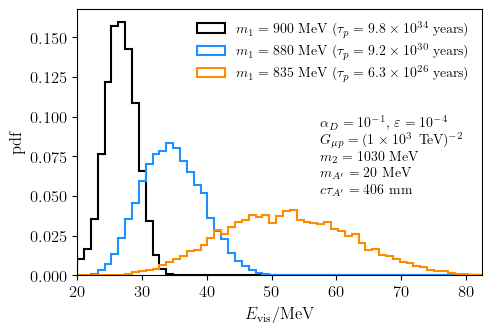

In [313]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(20, np.max(kin_pdecay_2['m_eee'])*1e3, 60)
ax.hist(kin_pdecay_3c['E_vis']*1e3, weights=weights_pdecay_3c/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='black', label=rf'$m_1 = {Benchmark3c.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_3c.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_4c['E_vis']*1e3, weights=weights_pdecay_4c/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='dodgerblue', label=rf'$m_1 = {Benchmark4c.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_4c.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_2c['E_vis']*1e3, weights=weights_pdecay_2c/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='darkorange', label=rf'$m_1 = {Benchmark2c.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_2c.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)


# Set labels and title
ax.set_xlabel(r'$E_{\rm vis}$/MeV')
# ax.set_ylabel(r'${d \tau_{p}/d m_{eee}}$ ($10^{32}$ years/MeV)')
ax.set_ylabel(r'pdf')
# ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_2*1e32*1e3/, notex=True)}$ years', fontsize=10)

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_descriptor = rf"\noindent$\alpha_D = 10^{{-1}},\, \varepsilon = 10^{{-4}}$\\$G_{{\mu p}} = ({Benchmark1.tex_scale}$ \,TeV$)^{{-2}}$\\$m_2 = {Benchmark1b.m2*1e3:.0f}$ MeV\\$m_{{A^\prime}} = {Benchmark1.maprime*1e3:.0f}$ MeV\\$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():0.0f}$~mm"
ax.text(0.6, 0.6, text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.legend(loc='upper right', fontsize=10, ncols=1, frameon=False)

# Add the vertical dashed line
cutoff = (const.m_proton - Benchmark2.m1 - Benchmark2.maprime)*1e3
ax.axvline(cutoff, linestyle='dashed', color='grey')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1c_Evis.pdf', dpi=300)

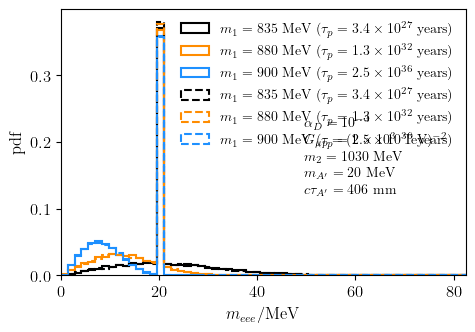

In [249]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, np.max(kin_pdecay_2['m_eee'])*1e3, 60)
ax.hist(kin_pdecay_2['m_ee1']*1e3, weights=weights_pdecay_2/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='black', label=rf'$m_1 = {Benchmark2.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_2.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_4['m_ee1']*1e3, weights=weights_pdecay_4/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='darkorange', label=rf'$m_1 = {Benchmark4.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_4.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_3['m_ee1']*1e3, weights=weights_pdecay_3/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='dodgerblue', label=rf'$m_1 = {Benchmark3.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_3.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)


ax.hist(kin_pdecay_2['m_ee2']*1e3, weights=weights_pdecay_2/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='black', ls='--', label=rf'$m_1 = {Benchmark2.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_2.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_4['m_ee2']*1e3, weights=weights_pdecay_4/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='darkorange', ls='--', label=rf'$m_1 = {Benchmark4.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_4.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)
ax.hist(kin_pdecay_3['m_ee2']*1e3, weights=weights_pdecay_3/np.diff(bins)[0], bins=bins, histtype='step', edgecolor='dodgerblue', ls='--', label=rf'$m_1 = {Benchmark3.m1*1e3:.0f}$ MeV ($\tau_p = {plot_tools.sci_notation(weights_pdecay_3.sum()*1e32, notex=True)}$ years)', lw=1.5, density=True)


# Set labels and title
ax.set_xlabel(r'$m_{eee}$/MeV')
# ax.set_ylabel(r'${d \tau_{p}/d m_{eee}}$ ($10^{32}$ years/MeV)')
ax.set_ylabel(r'pdf')
# ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_2*1e32*1e3/, notex=True)}$ years', fontsize=10)

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
text_descriptor = rf"\noindent$\alpha_D = 10^{{-1}}$\\$G_{{\mu p}} = ({Benchmark1.tex_scale}$ \,TeV$)^{{-2}}$\\$m_2 = {Benchmark1b.m2*1e3:.0f}$ MeV\\$m_{{A^\prime}} = {Benchmark1.maprime*1e3:.0f}$ MeV\\$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():0.0f}$~mm"
ax.text(0.6, 0.6, text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.legend(loc='upper right', fontsize=10, ncols=1, frameon=False)

# Add the vertical dashed line
cutoff = (const.m_proton - Benchmark2.m1 - Benchmark2.maprime)*1e3
ax.axvline(cutoff, linestyle='dashed', color='grey')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_mee1.png', bbox_inches='tight', dpi=300)

Text(0, 0.5, '$m_{ee2}$/MeV')

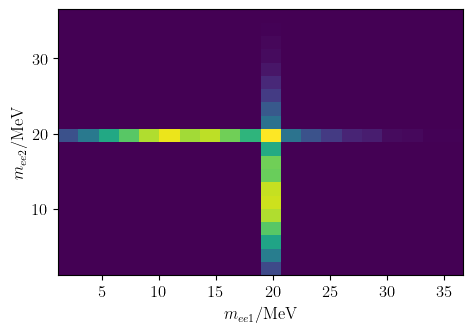

In [250]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, np.max(kin_pdecay_3['m_ee2'])*1e3, 40)
ax.hist2d(kin_pdecay_4['m_ee1']*1e3, kin_pdecay_4['m_ee2']*1e3, weights=weights_pdecay_4/np.diff(bins)[0], bins=20, cmap='viridis')

# Set labels and title
ax.set_xlabel(r'$m_{ee1}$/MeV')
ax.set_ylabel(r'$m_{ee2}$/MeV')
# ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_3.sum()*1e32, notex=True)}$ years', fontsize=10)
# Add the text box
# ax.text(0.025, 0.95, Benchmark3.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Save the figure to a PDF file
# fig.savefig(f'plots/ProtonDecay_model1_mee1_m1_{Benchmark3.m1:0.0f}_testnoMW.png', bbox_inches='tight', dpi=300)

Text(0, 0.5, '$m_{ee1}$/MeV')

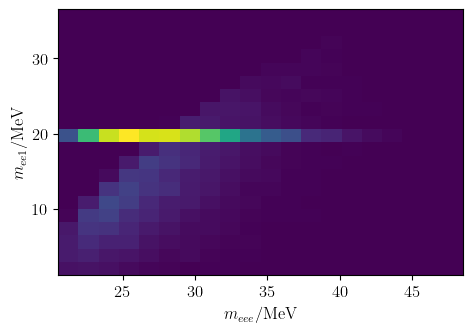

In [251]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
ax.hist2d(kin_pdecay_4['m_eee']*1e3, kin_pdecay_4['m_ee2']*1e3, weights=weights_pdecay_4/np.diff(bins)[0], bins=20, cmap='viridis')

# Set labels and title
ax.set_xlabel(r'$m_{eee}$/MeV')
ax.set_ylabel(r'$m_{ee1}$/MeV')
# ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_3.sum()*1e32, notex=True)}$ years', fontsize=10)
# Add the text box
# ax.text(0.025, 0.95, Benchmark3.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Save the figure to a PDF file
# fig.savefig(f'plots/ProtonDecay_model1_mee1_m1_{Benchmark3.m1:0.0f}_testnoMW.png', bbox_inches='tight', dpi=300)

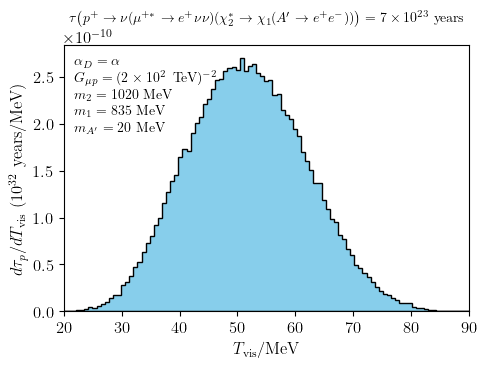

In [45]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(20, 90, 100)
ax.hist(kin_pdecay_2['T_vis']*1e3, weights=weights_full_2/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$T_{\mathrm{vis}}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d T_{\rm vis}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_2*1e32, notex=True, decimal_digits=0)}$ years', fontsize=10)

# ax.set_yscale('log')

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
ax.text(0.025, 0.95, Benchmark2.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Add the vertical dashed line
# cutoff = 938.27 - (m1+mAp)*1e3 - 3*0.511
# ax.axvline(cutoff, linestyle='dashed', color='grey')
# ax.text(cutoff+0.5, ax.get_ylim()[1]/10, r'$m_p - m_1 - 3 m_e$', rotation='vertical', color='grey', ha='left', va='bottom')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_Tvis_m1_{Benchmark2.m1:0.0f}.png', bbox_inches='tight', dpi=300)

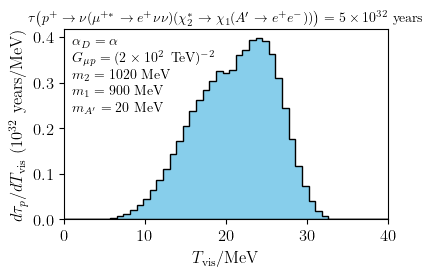

In [46]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(4, 2.5))

# Plot the histogram
bins = np.linspace(0, 40, 50)
ax.hist(kin_pdecay_3['T_vis']*1e3, weights=weights_full_3/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$T_{\mathrm{vis}}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d T_{\rm vis}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_3*1e32, notex=True, decimal_digits=0)}$ years', fontsize=10)

# ax.set_yscale('log')

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
ax.text(0.025, 0.95, Benchmark3.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_Tvis_m1_{Benchmark3.m1:0.0f}.png', bbox_inches='tight', dpi=300)

# Lifetimes as a function of Q

In [339]:
lifetimes = []
masses = np.linspace(0.835, const.m_proton - 0.020 - 0.003, 20, endpoint=True)
for m in masses:
    model = models.MuonCaptureModelI(m1=m, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD=0.1, epsilon=1e-4)
    lifetimes.append(get_p_lifetime(model))

stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 153136.14it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 136003.83it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 145285.11it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 160289.61it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 158879.15it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 160765.35it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 180795.86it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 148581.48it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 136106.35it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 162766.72it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 155166.59it/s]
stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 132746.94it/s]
stty

In [404]:
lifetimes_offshel = []
masses_offshell = np.linspace(0.835, const.m_proton - 3*const.m_e - 0.001, 20, endpoint=True)
for m in masses_offshell:
    model = models.MuonCaptureModelI(m1=m, m2=1.020, maprime=0.020, Gmup=Gmup, alphaD=0.1, epsilon=1e-4)
    lifetimes_offshel.append(get_p_lifetime_offshell(model))

stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 79479.75it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 88707.87it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 85655.24it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 87524.90it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 87571.61it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 87368.31it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 89921.29it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 92333.98it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 89104.82it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 80255.70it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 92265.44it/s]
stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 86670.53it/s]
stty: stdin isn'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mhostert/Repos/Mu2eExotica/MGevents/ProtonDecayModel1/Events/custom_run_9.37e-01_1.02e+00_2.00e-02/unweighted_events.lhe.gz'

In [412]:
masses_offshell = np.linspace(0.835, const.m_proton - 3.1*const.m_e, 20, endpoint=True)[:-1]

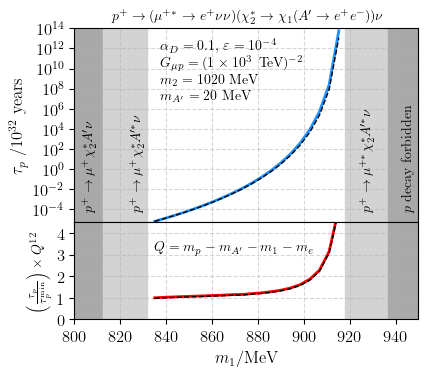

In [811]:
import matplotlib.gridspec as gridspec

# fig, ax = plot_tools.std_fig(figsize=(5, 3.5))
# Create a gridspec object
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
plt.savefig(f'plots/Proton_decay_mass_dependence.pdf', dpi=300, bbox_inches='tight')

plt.subplots_adjust(hspace=0.0)
# Create the first axis (ax) using the first slot of the gridspec
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

y = lifetimes
y_rescale = lifetimes*((const.m_proton - (0.02 + masses) - const.m_e))**12
y_rescale /= np.min(y_rescale)
x = masses*1e3
ax.plot(x, y, color='dodgerblue', lw=2)
ax2.plot(x, y_rescale, color='red', lw=2)
         
# y = lifetimes_offshel
# x = masses_offshell*1e3
# y_rescale = lifetimes_offshel*((const.m_proton - masses_offshell - 3*const.m_e))**12
# y_rescale /= np.min(y_rescale)
# ax.plot(x, y, color='red', lw=1)
# ax2.plot(x, y_rescale, color='red', lw=2)

# Set labels and title
ax2.set_xlabel(r'$m_1$/MeV')
ax.set_ylabel(r'$\tau_{p}$ /$10^{32}$ years')
ax2.set_ylabel(r'$\left( \frac{\tau_{p}}{\tau_{p}^{\rm min}}\right) \times Q^{12}$', fontsize=10)
ax.set_title(fr'$p^+ \to (\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\nu$', fontsize=10)

ax.set_xlim(830, 930)

# Add the text box
descript = '\\noindent$\\alpha_D = 0.1, \, \\varepsilon = 10^{-4}$ \\\\$G_{\\mu p} = (1\\times 10^{3}$ \\,TeV$)^{-2}$\\\\$m_2 = 1020$ MeV\\\\$m_{A^\\prime} = 20$ MeV'
ax.text(0.25, 0.95, descript, transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax2.text(0.23, 0.8, r'$Q = m_p - m_{A^\prime} - m_1 - m_e$', transform=ax2.transAxes, fontsize=10, verticalalignment='top')


# Add the vertical dashed line
cutoff1 = (const.m_proton - Benchmark2.maprime - const.m_e)*1e3
cutoff2 = (const.m_proton - 3*const.m_e)*1e3
cutoff3 = (const.m_proton - const.m_mu - 2*const.m_e)*1e3
cutoff4 = (const.m_proton - const.m_mu - 0.02)*1e3
ax.fill_betweenx([0,1e100], [cutoff1,cutoff1], [cutoff2,cutoff2], linestyle='-', color='lightgrey')
ax.fill_betweenx([0,1e100], [cutoff2,cutoff2], [1e3,1e3], linestyle='-', color='darkgrey')
ax.fill_betweenx([0,1e100], [0,0], [cutoff4,cutoff4], linestyle='-', color='darkgrey')
ax.fill_betweenx([0,1e100], [cutoff4,cutoff4], [cutoff3,cutoff3], linestyle='-', color='lightgrey')

ax2.fill_betweenx([0,10], [cutoff1,cutoff1], [cutoff2,cutoff2], linestyle='-', color='lightgrey')
ax2.fill_betweenx([0,10], [cutoff2,cutoff2], [1e3,1e3], linestyle='-', color='darkgrey')
ax2.fill_betweenx([0,10], [0,0], [cutoff4,cutoff4], linestyle='-', color='darkgrey')
ax2.fill_betweenx([0,10], [cutoff4,cutoff4], [cutoff3,cutoff3], linestyle='-', color='lightgrey')

ax.text(0.02, 0.05, r'$p^+ \to \mu^+ \chi_2^* A^\prime\nu$', transform=ax.transAxes, fontsize=10, verticalalignment='bottom', rotation = 90)
ax.text(0.16, 0.05, r'$p^+ \to \mu^+ \chi_2^* A^{{\prime *}}\nu$', transform=ax.transAxes, fontsize=10, verticalalignment='bottom', rotation = 90)
ax.text(0.83, 0.05, r'$p^+ \to \mu^{{+ *}}\chi_2^* A^{{\prime *}}\nu$', transform=ax.transAxes, fontsize=10, verticalalignment='bottom', rotation = 90)
ax.text(0.95, 0.05, r'$p$ decay forbidden', transform=ax.transAxes, fontsize=10, verticalalignment='bottom', rotation = 90)

ax.set_yscale('log')
# ax2.set_yscale('log')

yticks = np.geomspace(1e-6, 1e14, 21, endpoint=True)[::2]
ax.set_yticks(yticks)
ax2.set_yticks([0,1,2,3,4])

ax.set_xticklabels([])
ax.set_xticks(np.arange(800,960, 20))
ax2.set_xticks(np.arange(800,960, 20))

ax.set_xlim(800, 950)
ax2.set_xlim(800, 950)

ax.set_ylim(5e-6, yticks[-1])
ax2.set_ylim(0, 4.5)

ax.grid(which='both', axis='both', linestyle='--', alpha=0.5)
ax2.grid(which='both', axis='both', linestyle='--', alpha=0.5)

Gamma_mu = 2.995e-19
Gamma_mup_chi2nu = 2*Gmup**2/const.Gf**2 * const.get_decay_rate_in_s(1/700)
Qrelease = (const.m_proton - (0.02 + masses) - const.m_e)
offshellness = np.abs(const.m_proton - 1.020 - const.m_mu)
Gamma_p_estimate = (Gamma_mup_chi2nu * Gamma_mu * Benchmark1.Gammachi2)*(Qrelease/offshellness)**12/(offshellness/3)**2
tau_p_estimate = const.get_decay_rate_in_1e32_years(Gamma_p_estimate)

ax.plot(masses*1e3, tau_p_estimate, color='black', linestyle='--', lw=1)
ax2.plot(masses*1e3, lifetimes/tau_p_estimate, color='black', linestyle='--', lw=1)

# Save the figure to a PDF file
plt.savefig(f'plots/Proton_decay_mass_dependence.pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'plots/Proton_decay_mass_dependence.png', dpi=300, bbox_inches='tight')